# Brain Tumor Segmentation (BraTS) with MKL-DNN

In this code example, we apply the U-Net architecture to segment brain tumors from raw MRI scans. With relatively little data we are able to train a U-Net model to accurately predict where tumors exist. The below MRI brain scans highlight brain tumor matter segmented using deep learning. 

For a more detailed explanation on the accuracy of these predictions and U-Net, please reference the **"Brain Tumor Segmentation with OpenVINO™"** introduction. 

<img src="images/figure1.png">

## Demonstration objectives
* Healthcare use-case demo
* **MKL-DNN** library in action
* U-Net based segmentation on edge hardware
* Inference performance comparison between MKL-enabled TensorFlow vs. MKL-disabled TensorFlow

## Step 0: Set Up

### 0.1: Import dependencies

Run the below cells to import dependencies (select the cell and use **Ctrl+enter** to run the cell). 

In [14]:
import sys, os 
import ipywidgets as widgets
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *
from IPython.display import display

## Step 1. Create the Queue Jobs
Now we configure MKL-DNN (Math Kernel Library for Deep Neural Networks), a library that utilizes the full power of Intel® processors. We will setup up both a **stock (MKL-disabled)** and **optimized (MKL-enabled)** version of TensorFlow and the associated conda environments to compare their performance. Note that these steps may take a few minutes as we will be installing packages locally to your instance in the DevCloud.

Here we will create a job to run on the edge using the **MKL-disabled** TensorFlow virtual environment. 

In [15]:
#Check if conda env with stock tensorflow already exists
stocktf_exist = !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda info --envs | grep "stocktf "
if not stocktf_exist:
    print("Create stocktf conda environment")
    !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda config --set auto_activate_base false
    !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda env create -f "stocktf.yml"
else:
    print("stocktf conda environment exists")

stocktf conda environment exists


In [16]:
%%writefile healthcare_job_stocktf.sh

# Prevent error and output files from being saved to DevCloud
#PBS -e /dev/null

cd $PBS_O_WORKDIR 
# Running the code inside stocktf conda env
SAMPLEPATH=$PBS_O_WORKDIR
export PATH=/glob/supplementary-software/versions/Miniconda/miniconda3/condabin:$PATH
source /glob/supplementary-software/versions/Miniconda/miniconda3/etc/profile.d/conda.sh
conda activate stocktf
python3 healthcare_no_openvino.py -r $1
conda deactivate

Overwriting healthcare_job_stocktf.sh


Here we will create a job to run on the edge using the **MKL-enabled** TensorFlow virtual environment. 

In [17]:
#Check if conda env with optimized tensorflow using mkl already exists
mkltf_exist = !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda info --envs | grep "mkltf "
if not mkltf_exist:
    print("Create mkltf conda environment")
    !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda config --set auto_activate_base false
    !/glob/supplementary-software/versions/Miniconda/miniconda3/condabin/conda env create -f "mkltf.yml"
else:
    print("mkltf conda environment exists")

mkltf conda environment exists


In [18]:
%%writefile healthcare_job_mkltf.sh

# Prevent error and output files from being saved to DevCloud
#PBS -e /dev/null

cd $PBS_O_WORKDIR 
# Running the code inside mkltf conda env
SAMPLEPATH=$PBS_O_WORKDIR
export PATH=/glob/supplementary-software/versions/Miniconda/miniconda3/condabin:$PATH
source /glob/supplementary-software/versions/Miniconda/miniconda3/etc/profile.d/conda.sh
conda activate mkltf
python3 healthcare_no_openvino.py -r $1 
conda deactivate

Overwriting healthcare_job_mkltf.sh


## Step 2. Inference Time!
Here we create job files and submit them to different edge compute nodes. They will go into a queue and run once the compute resources are available. 

#### Submitting to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run the CPU inside stocktf conda environment.

In [19]:
core_stocktf = !qsub healthcare_job_stocktf.sh -l nodes=1:idc001skl:tank-870:i5-6500te -F "results/"
print(core_stocktf[0]) 
if core_stocktf:
    progressIndicator('results/'+core_stocktf[0], 'i_progress.txt', "Processing", 0, 100)

1360.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel® 
    Xeon® Processor E3-1268L v5</a>. The inference workload will run on the CPU inside stocktf conda environment.

In [20]:
#Submit job to the queue
xeon_stocktf = !qsub healthcare_job_stocktf.sh -l nodes=1:idc007xv5:e3-1268l-v5 -F "results/"
print(xeon_stocktf[0]) 
if xeon_stocktf:
    progressIndicator('results/'+xeon_stocktf[0], 'i_progress.txt', "Processing", 0, 100)

1370.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run the CPU inside mkltf conda environment.

In [21]:
core_mkltf = !qsub healthcare_job_mkltf.sh -l nodes=1:idc001skl:tank-870:i5-6500te  -F "results/"
print(core_mkltf[0]) 
if core_mkltf:
    progressIndicator('results/'+core_mkltf[0], 'i_progress.txt', "Processing", 0, 100)

1371.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel® 
    Xeon® Processor E3-1268L v5</a>. The inference workload will run on the CPU inside mkltf conda environment.

In [22]:
#Submit job to the queue
xeon_mkltf = !qsub healthcare_job_mkltf.sh -l nodes=1:idc007xv5:e3-1268l-v5  -F "results/"
print(xeon_mkltf[0]) 
if xeon_mkltf:
    progressIndicator('results/'+xeon_mkltf[0], 'i_progress.txt', "Processing", 0, 100)

1372.v-qsvr-1.devcloud-edge


You can view the status of the jobs below. 

In [23]:
liveQstat()

Output(layout=Layout(border='1px solid gray', width='100%'))

Button(description='Stop', style=ButtonStyle())

## Step 3. Results
### 3.1: Image Comparison
Here, we visualize our predictions. We can observe the frame rate, execution time, and dice coefficient (a value that describes the similarity between the ground truth and the prediction, with 1.0 indicating 100% accuracy). Note that it may take a few seconds to display the results. 

In [24]:
outputHTML('IEI Tank (Intel Core CPU)',
          'results/'+core_stocktf[0], '.png')

In [28]:
outputHTML('IEI Tank Xeon (Intel Xeon CPU)',
          'results/'+xeon_stocktf[0], '.png')

In [26]:
outputHTML('IEI Tank (Intel Core CPU)',
          'results/'+core_mkltf[0], '.png')

In [27]:
outputHTML('IEI Tank Xeon (Intel Xeon CPU)',
          'results/'+xeon_mkltf[0], '.png')

### 3.2: Architecture Comparison
Finally, we benchmark the processing time and frames per second on different architectures with MKL-DNN enabled and disabled.

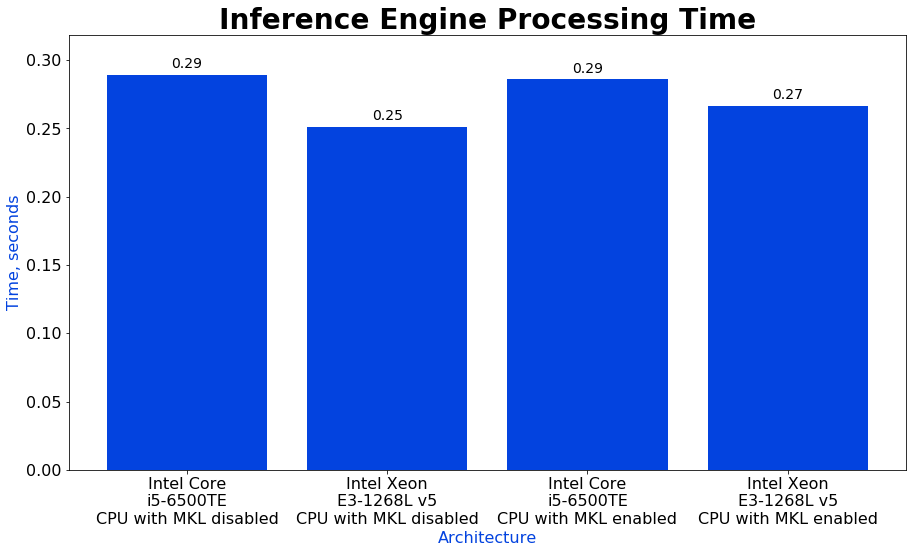

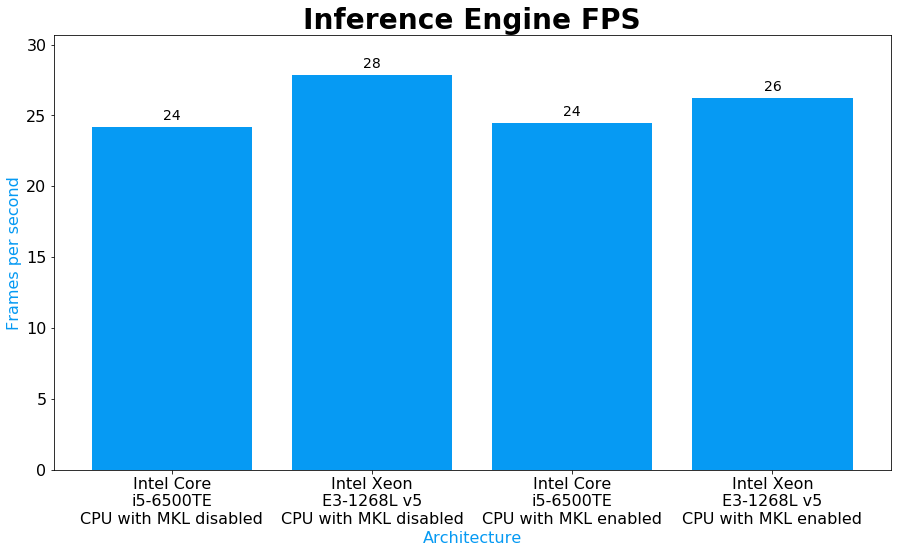

In [29]:
arch_list = [('core_stocktf', 'Intel Core\ni5-6500TE\nCPU with MKL disabled'),
             ('xeon_stocktf', 'Intel Xeon\nE3-1268L v5\nCPU with MKL disabled'),
             ('core_mkltf', 'Intel Core\ni5-6500TE\nCPU with MKL enabled'),
             ('xeon_mkltf', 'Intel Xeon\nE3-1268L v5\nCPU with MKL enabled')
             ]

stats_list = []
for job, a_name in arch_list:
    if job in vars():
        stats_list.append(('results/'+vars()[job][0]+'/stats.txt', a_name))
    else:
        stats_list.append(('placeholder'+job, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )